In [1]:
from bs4 import BeautifulSoup
from collections import Counter
from collections import defaultdict
from datetime import datetime

import math
import numpy as np
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import requests 

# pgeocode is a package we use to retrieve the lat/lon coordinates from a zip code
!pip install pgeocode
import pgeocode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Reading in the data

First, we need to read in the data which is in the form of 10 different excel files. The approach here is to read each file into a dataframe and then concatenate all the dataframes together.

In [2]:
%%time

data = []

for file in os.listdir():
    if file.endswith(".xlsx"):
        data.append(pd.read_excel(file))

CPU times: user 1min 55s, sys: 726 ms, total: 1min 56s
Wall time: 2min 5s


In [3]:
data = pd.concat(data, axis=0, ignore_index=True)

In [4]:
data

,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,...,Lineitem fulfillment status,Billing City,Billing Zip,Billing Province,Billing Country,Shipping City,Shipping Zip,Shipping Province,Shipping Country,Cancelled at
0,93689,1459.0,paid,2021-07-11 14:46:00,fulfilled,2021-07-12 20:49:00,yes,USD,54.94,0.00,...,fulfilled,Sylvania,'43560,OH,US,Sylvania,'43560,OH,US,NaT
1,93689,1459.0,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,...,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,93689,1459.0,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,...,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,93689,1459.0,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,...,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,93688,1460.0,paid,2021-07-11 14:46:00,fulfilled,2021-07-12 20:49:00,no,USD,101.95,0.00,...,fulfilled,Blaine,'98230,WA,US,Blaine,'98230,WA,US,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394634,93691,9901.0,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,...,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
394635,93691,9901.0,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,...,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
394636,93691,9901.0,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,...,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
394637,93691,9901.0,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,...,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


# High Level Insights

In [5]:
len(set(data["Name"]))

111470

Looks like there's only 111,470 unique order ID numbers. This means even though we have almost 400,000 observations, we're actually dealing with 111,000 actual orders.

In [6]:
dict(reversed(sorted(Counter(data["Discount Code"]).items(), key=lambda x: x[1])))

{nan: 381339,
 "Discount 'Build Your Own Gift Set'": 3696,
 'RISEUP': 1921,
 'Custom discount': 1672,
 'Discount for bundle "Build Your Own Gift Set"': 1466,
 "Discount for bundle 'Build Your Own Gift Set'": 715,
 'SPICECLUBBING': 467,
 'FIRSTSPICE': 375,
 'BONAPPETIT': 311,
 'SPICEITUP': 289,
 "Discount 'Build Your Own Gift Set', 'Build Your Own Gift Set'": 232,
 'FAMILYMEAL': 197,
 'replacement': 164,
 'FLAVORFALL': 133,
 'FREESHIP': 127,
 'HOMECOOKING': 105,
 'SUMMERTHYME': 102,
 'Replacement': 92,
 'NYANZA': 86,
 'FREEPANCAKES': 80,
 'Sample': 77,
 'Carro Sales Channel Retailer Wholesale Price': 76,
 'SAVORYSWEET': 44,
 'SOOM': 44,
 'MORECOOKIES': 43,
 'Discount for bundles "Build Your Own Gift Set", "Build Your Own Gift Set"': 40,
 "Discount 'Build Your Own Gift Set', 'Build Your Own Gift Set', 'Build Your Own Gift Set'": 34,
 'Samples': 34,
 "Discount for bundles 'Build Your Own Gift Set', 'Build Your Own Gift Set'": 27,
 'samples': 24,
 'Pay What You Can': 22,
 'SPICESPICEBABY':

Above is looking at the usage of all the discount codes. Most orders (381,339 out of 394,639) were not placed with any codes. But the most popular seem to be the 'Build Your Own Gift Set' and 'RISEUP'.

In [7]:
len(set(data["Email"]))

53740

Looking at how many unique customers placed orders, we have 53,740 unique emails.

# Data Cleaning & Transformations

We want to cut the dataset down to filter out wholesale orders (over \$700), free orders (\$0 order total), and orders without Email information (cannot gain customer insights).

We're also dropping some of the columns we won't be using going forward to reduce clutter.

In [8]:
data = data.loc[(data['Total'] < 700) & (data['Total'] > 0) & (data['Email'].isnull() == False)]
data.drop(['Financial Status', 'Fulfillment Status', 'Fulfilled at', 'Currency', 'Subtotal', 'Shipping', 'Taxes', 'Shipping Method', 'Lineitem quantity', 'Lineitem price', 'Lineitem compare at price', 'Lineitem sku', 'Lineitem requires shipping', 'Lineitem taxable', 'Lineitem fulfillment status'], axis=1)

,Name,Email,Paid at,Accepts Marketing,Total,Discount Code,Discount Amount,Created at,Lineitem name,Billing City,Billing Zip,Billing Province,Billing Country,Shipping City,Shipping Zip,Shipping Province,Shipping Country,Cancelled at
0,93689,1459.0,2021-07-11 14:46:00,yes,54.94,NaN,0.0,2021-07-11 14:46:00,Ground Laurel Bay Leaves - 1.5 oz glass jar,Sylvania,'43560,OH,US,Sylvania,'43560,OH,US,NaT
4,93688,1460.0,2021-07-11 14:46:00,no,101.95,NaN,0.0,2021-07-11 14:46:00,Spice-Infused Maple Syrups *Collaboration* - R...,Blaine,'98230,WA,US,Blaine,'98230,WA,US,NaT
9,93687,1461.0,2021-07-11 14:44:00,yes,50.96,NaN,0.0,2021-07-11 14:44:00,"Nyanza Vanilla - 2 Pods, Dry Extract Grade (Ba...",greer,'29650,SC,US,greer,'29650,SC,US,NaT
13,93686,1462.0,2021-07-11 14:43:00,yes,55.94,NaN,0.0,2021-07-11 14:43:00,Cobanero Chili Hot Honey *Collaboration* - 5.5...,Seattle,98103-7663,WA,US,Seattle,98103-7663,WA,US,NaT
16,93685,1463.0,2021-07-11 14:42:00,no,34.96,NaN,0.0,2021-07-11 14:42:00,Purple Stripe Garlic - 1.8 oz glass jar,Toppenish,'98948,WA,US,Toppenish,'98948,WA,US,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394620,93694,1094.0,2021-07-11 14:52:00,no,46.40,NaN,0.0,2021-07-11 14:52:00,Smoked Piment√≥n Paprika - 1.8 oz glass jar,Oak Park,'60302,IL,US,Oak Park,'60302,IL,US,NaT
394626,93693,5433.0,2021-07-11 14:51:00,yes,34.96,NaN,0.0,2021-07-11 14:51:00,Silk Chili Flakes - 1.8 oz glass jar,Altadena,'91001,CA,US,Altadena,'91001,CA,US,NaT
394629,93692,28609.0,2021-07-11 14:47:00,yes,30.96,NaN,0.0,2021-07-11 14:47:00,Morogoro Cacao Powder - 1.75 oz glass jar,North Potomac,'20878,MD,US,North Potomac,'20878,MD,US,NaT
394633,93691,9901.0,2021-07-11 14:47:00,no,58.94,NaN,0.0,2021-07-11 14:47:00,Floyd Cardoz Masalas - Kashmiri Masala - 2.2 o...,Irvine,'92612,CA,US,Irvine,'92612,CA,US,NaT


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc9e915ba30>]],
      dtype=object)

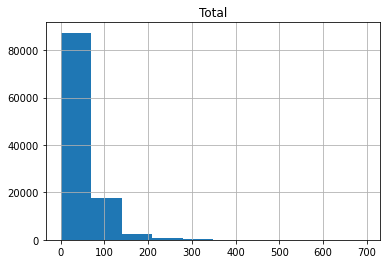

In [10]:
data.hist(column="Total")

Looking at the histogram above, we see that we've cut out large orders and most of the orders are between \$0 - \$400.

Next we'll be reorganizing the data to look at it from the customer perspective. The four dictionaries we're making will represent total order amount, zip code, total discount applied, and marketing status for each customer email in the dataset.

In [11]:
email_total = defaultdict(int)
email_zip = {}
email_disc = defaultdict(int)
email_marketing = {}

for index, row in data.iterrows():
  email_total[row['Email']] += row['Total']
  email_zip[row['Email']] = row['Shipping Zip']
  email_disc[row['Email']] += row['Discount Amount']
  email_marketing[row['Email']] = row['Accepts Marketing']

Now, we're also seperating the customer information into "buckets". The idea is that the lower_spending bucket holds the 33% of customers who have the lowest spending, middle_spending bucket holds the middle 33% of customers, and upper_spending holds the 33% of customers with the highest spending.

The goal with this is to try to understand which factors are common among upper_spending customers as they're bringing in more revenue.

In [12]:
email_spending_bucket = np.array_split(sorted(email_total.items(), key=lambda email_total: email_total[1]), 3)
lower_spending = [item for item in email_spending_bucket[0].tolist()]
middle_spending = [item for item in email_spending_bucket[1].tolist()]
upper_spending = [item for item in email_spending_bucket[2].tolist()]

In [13]:
lower_disc = [email_disc[user[0]] for user in lower_spending]
middle_disc = [email_disc[user[0]] for user in middle_spending]
upper_disc = [email_disc[user[0]] for user in upper_spending]

# Plots & Visualizations

For each bucket, we're making a scatter plot which is plotting the total order revenue for each customer along with the total amount applied in discount codes.

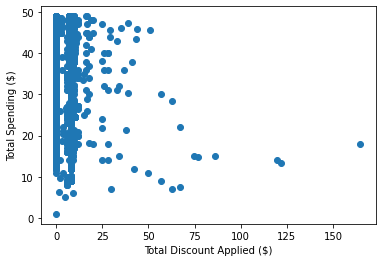

In [14]:
plt.xlabel("Total Discount Applied ($)")
plt.ylabel("Total Spending ($)")
plt.scatter(lower_disc, list(zip(*lower_spending))[1])

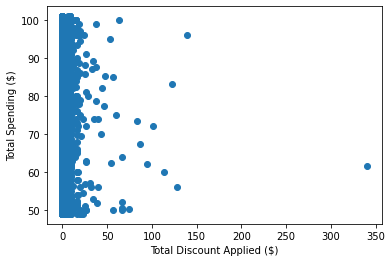

In [15]:
plt.xlabel("Total Discount Applied ($)")
plt.ylabel("Total Spending ($)")
plt.scatter(middle_disc, list(zip(*middle_spending))[1])

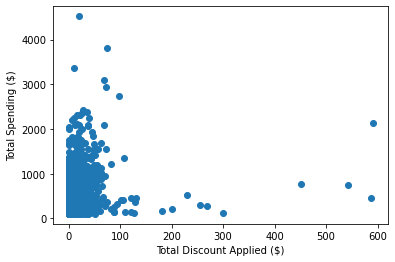

In [16]:
plt.xlabel("Total Discount Applied ($)")
plt.ylabel("Total Spending ($)")
plt.scatter(upper_disc, list(zip(*upper_spending))[1])

The scatter plot doesn't give a ton of insight and many of the plots are overlapping. We decided to try a bar plot to visualize this relationship instead.

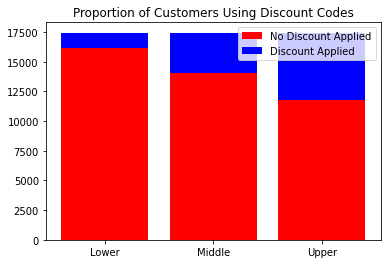

In [17]:
x = ['Lower', 'Middle', 'Upper']
y1 = [lower_disc.count(0), middle_disc.count(0), upper_disc.count(0)]
y2 = [len(lower_disc) - lower_disc.count(0), len(middle_disc) - middle_disc.count(0), len(upper_disc) - upper_disc.count(0)]

plt.bar(x, y1, color='r', label='No Discount Applied')
plt.bar(x, y2, bottom=y1, color='b', label='Discount Applied')

plt.title('Proportion of Customers Using Discount Codes')
plt.legend()

plt.show()

Now we're starting to see some clearer insight. This first plot tells us that the customers who are spending more are also using more discount codes. Almost 1/3 of upper bucket customers are using discount codes.

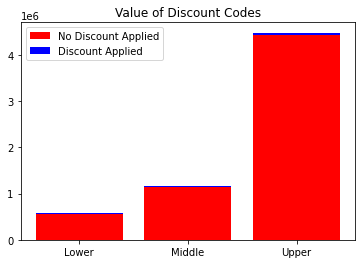

In [18]:
x = ['Lower', 'Middle', 'Upper']
y1 = [sum(list(zip(*lower_spending))[1]) - sum(lower_disc), sum(list(zip(*middle_spending))[1]) - sum(middle_disc), sum(list(zip(*upper_spending))[1]) - sum(upper_disc)]
y2 = [sum(lower_disc), sum(middle_disc), sum(upper_disc)]

plt.bar(x, y1, color='r', label='No Discount Applied')
plt.bar(x, y2, bottom=y1, color='b', label='Discount Applied')

plt.title('Value of Discount Codes')
plt.legend()

plt.show()

This plot is showing us that even though 1/3 of upper bucket customers are using discount codes, the actual discount applied is negligible compared to the total order revenue coming in.

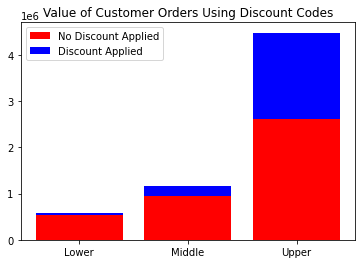

In [19]:
lower_emails = set([item[0] for item in email_spending_bucket[0].tolist()])
middle_emails = set([item[0] for item in email_spending_bucket[1].tolist()])
upper_emails = set([item[0] for item in email_spending_bucket[2].tolist()])

lower_disc_total = middle_disc_total = upper_disc_total = 0

for email in email_disc:
  if email_disc[email] > 0:
    if email in lower_emails:
      lower_disc_total += email_total[email]
    elif email in middle_emails:
      middle_disc_total += email_total[email]
    elif email in upper_emails:
      upper_disc_total += email_total[email]


x = ['Lower', 'Middle', 'Upper']
y1 = [sum(list(zip(*lower_spending))[1]) - lower_disc_total, sum(list(zip(*middle_spending))[1]) - middle_disc_total, sum(list(zip(*upper_spending))[1]) - upper_disc_total]
y2 = [lower_disc_total, middle_disc_total, upper_disc_total]

plt.bar(x, y1, color='r', label='No Discount Applied')
plt.bar(x, y2, bottom=y1, color='b', label='Discount Applied')

plt.title('Value of Customer Orders Using Discount Codes')
plt.legend()

plt.show()

Now it gets really interesting. This plot is showing the total revenue from each bucket similar to the previous chart however this one seperates the revenue into customers who don't use discount codes (red) and customers who do use them (blue).

There's two point takeaways here:
1.   The revenue coming in from the upper bucket dominates both the lower and middle buckets. This means even though it's only 33% of customers, they're bringing in close to 66% of the revenue.
2.   Almost half of the upper bucket customers are using discount codes. We've established that these customers are valuable and it looks like they like discount codes. It's also been established in the previous plot that the codes don't cost much.



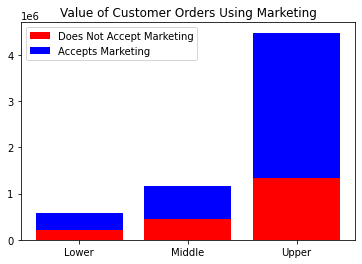

In [20]:
lower_newsletter_total = middle_newsletter_total = upper_newsletter_total = 0

for email in email_marketing:
  if email_marketing[email] == 'yes':
    if email in lower_emails:
      lower_newsletter_total += email_total[email]
    elif email in middle_emails:
      middle_newsletter_total += email_total[email]
    elif email in upper_emails:
      upper_newsletter_total += email_total[email]

x = ['Lower', 'Middle', 'Upper']
y1 = [sum(list(zip(*lower_spending))[1]) - lower_newsletter_total, sum(list(zip(*middle_spending))[1]) - middle_newsletter_total, sum(list(zip(*upper_spending))[1]) - upper_newsletter_total]
y2 = [lower_newsletter_total, middle_newsletter_total, upper_newsletter_total]

plt.bar(x, y1, color='r', label='Does Not Accept Marketing')
plt.bar(x, y2, bottom=y1, color='b', label='Accepts Marketing')

plt.title('Value of Customer Orders Using Marketing')
plt.legend()

plt.show()

The focus in this plot is shifting towards marketing. The blue represents customers who accept marketing the red represents customers who do not.

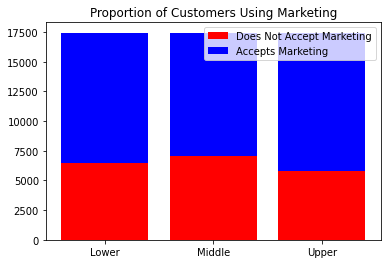

In [21]:
lower_marketing= [email_marketing[user[0]] for user in lower_spending]
middle_marketing = [email_marketing[user[0]] for user in middle_spending]
upper_marketing = [email_marketing[user[0]] for user in upper_spending]

x = ['Lower', 'Middle', 'Upper']
y1 = [len(lower_marketing) - lower_marketing.count('yes'), len(middle_marketing) - middle_marketing.count('yes'), len(upper_marketing) - upper_marketing.count('yes')]
y2 = [lower_marketing.count('yes'), middle_marketing.count('yes'), upper_marketing.count('yes')]

plt.bar(x, y1, color='r', label='Does Not Accept Marketing')
plt.bar(x, y2, bottom=y1, color='b', label='Accepts Marketing')

plt.title('Proportion of Customers Using Marketing')
plt.legend()

plt.show()

This plot is similar to the one from before but just looking at how many of the customers in each bucket are using marketing, rather than from an order revenue perspective.

In [22]:
data['Shipping Zip'] = data['Shipping Zip'].astype(str)
data['Shipping Zip'] = data['Shipping Zip'].apply(lambda x : x[1:] if x[0] not in {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'} else x)
data['Shipping Zip'] = data['Shipping Zip'].apply(lambda x : x[:5] if len(x) > 5 else x)
data.head()

<ipython-input-22-e777329c3362>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Shipping Zip'] = data['Shipping Zip'].astype(str)
<ipython-input-22-e777329c3362>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Shipping Zip'] = data['Shipping Zip'].apply(lambda x : x[1:] if x[0] not in {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'} else x)
<ipython-input-22-e777329c3362>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,...,Lineitem fulfillment status,Billing City,Billing Zip,Billing Province,Billing Country,Shipping City,Shipping Zip,Shipping Province,Shipping Country,Cancelled at
0,93689,1459.0,paid,2021-07-11 14:46:00,fulfilled,2021-07-12 20:49:00,yes,USD,54.94,0.00,...,fulfilled,Sylvania,'43560,OH,US,Sylvania,43560,OH,US,NaT
4,93688,1460.0,paid,2021-07-11 14:46:00,fulfilled,2021-07-12 20:49:00,no,USD,101.95,0.00,...,fulfilled,Blaine,'98230,WA,US,Blaine,98230,WA,US,NaT
9,93687,1461.0,paid,2021-07-11 14:44:00,fulfilled,2021-07-12 20:49:00,yes,USD,50.96,0.00,...,fulfilled,greer,'29650,SC,US,greer,29650,SC,US,NaT
13,93686,1462.0,paid,2021-07-11 14:43:00,fulfilled,2021-07-12 20:49:00,yes,USD,55.94,0.00,...,fulfilled,Seattle,98103-7663,WA,US,Seattle,98103,WA,US,NaT
16,93685,1463.0,paid,2021-07-11 14:42:00,fulfilled,2021-07-12 20:50:00,no,USD,28.97,5.99,...,fulfilled,Toppenish,'98948,WA,US,Toppenish,98948,WA,US,NaT


The code block above is just more cleaning. We're parsing the zip code column into a more friendly format for later.

# Correlations

Next, we're making a dictionary called email_info. The approach is pretty inefficient but the dictionary will store the following information for each customer (email). Total number of orders places, which dates those orders were places, if they used discount codes, and which zip code this customer is from.

We're also shifting our focus to order frequency rather than total order amount.

In [23]:
email_info = defaultdict(dict)

for _, row in data.iterrows():
  if "Orders" not in email_info[row["Email"]]:
    email_info[row["Email"]]["Orders"] = 0
  if "Dates" not in email_info[row["Email"]]:
    email_info[row["Email"]]["Dates"] = []
  if "Codes" not in email_info[row["Email"]]:
    email_info[row["Email"]]["Codes"] = False

  email_info[row["Email"]]["Orders"] += 1
  email_info[row["Email"]]["Dates"].append(row["Paid at"])
  email_info[row["Email"]]["Zip Code"] = row["Shipping Zip"]

  if type(row["Discount Code"]) == str:
    email_info[row["Email"]]["Codes"] = True

Using the data from email_info, we're making a new dataframe to store all this information in a more easy to use format.

The only extra logic here is using the order dates to compute "Time Delta". This column is just representing the average gap between orders in days. If the customer placed just 1 order, the time delta is infinity.

From "Time Delta" we also created "Short Delta". This column is true if the time delta is below 90 days and false otherwise. The reason we added this column was to get better correlations. I was thinking it would be a stat error otherwise. For example, every row with Orders=1 will also have Time Delta=inf. This is guarenteeing we see some type of negative correlation.

In [24]:
def daysdiff(a, b):
  return (a.to_pydatetime() - b.to_pydatetime()).days

emails = []
orders = []
delta_time = []
short_delta = []
zip_codes = []
discount_codes = []

for email in email_info:
  emails.append(email)
  orders.append(email_info[email]["Orders"])
  zip_codes.append(email_info[email]["Zip Code"])
  discount_codes.append(email_info[email]["Codes"])

  dates = sorted(email_info[email]["Dates"])
  if len(dates) < 2:
    average = float("inf")
  else:
    average = sum(daysdiff(b, a) for a, b in zip(dates, dates[1:])) / (len(dates) - 1)
  delta_time.append(average)

  short_delta.append(average < 90)

freq_df = pd.DataFrame(
    {
        "Email": emails,
        "Orders": orders,
        "Discount Codes": discount_codes,
        "Zip Codes": zip_codes,
        "Time Delta": delta_time,
        "Short Delta": short_delta,
    }
)

In [25]:
freq_df.head()

,Email,Orders,Discount Codes,Zip Codes,Time Delta,Short Delta
0,1459.0,2,False,43560,132.000000,False
1,1460.0,9,False,98230,61.875000,True
2,1461.0,21,True,29650,27.850000,True
3,1462.0,18,True,98103,33.235294,True
4,1463.0,5,False,98948,132.250000,False


In [26]:
freq_df.corr()

,Email,Orders,Discount Codes,Time Delta,Short Delta
Email,1.000000,-0.393660,-0.101690,0.051100,-0.260084
Orders,-0.393660,1.000000,0.205734,-0.328251,0.550863
Discount Codes,-0.101690,0.205734,1.000000,-0.084766,0.140693
Time Delta,0.051100,-0.328251,-0.084766,1.000000,-0.684985
Short Delta,-0.260084,0.550863,0.140693,-0.684985,1.000000


Looking at the correlation table above, there's some new insights.

*   Orders has a 0.21 correlation with Discount Codes. This is smaller but further supports the idea that discount codes promote more spending and more orders.
*   Orders has a 0.55 correlation with Short Delta. This is more significant and gives us the insight that customers who place additional orders sooner are also more likely to place more orders down the line.



In the snippet below, we're adding the "bucket" information to the original dataframe so we can easily use it later. Also encoding the lower, middle, upper to 0, 1, 2.

In [27]:
spending_group = []

lower_emails = set(lower_emails)
middle_emails = set(middle_emails)
upper_emails = set(upper_emails)

for index, row in data.iterrows():
  if (row['Email'] in lower_emails):
    spending_group.append(0)
  if (row['Email'] in middle_emails):
    spending_group.append(1)
  if (row['Email'] in upper_emails):
    spending_group.append(2)

data['Bucket'] = spending_group

<ipython-input-27-7c453fd77624>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Bucket'] = spending_group


In [28]:
data.columns

Index(['Name', 'Email', 'Financial Status', 'Paid at', 'Fulfillment Status',
       'Fulfilled at', 'Accepts Marketing', 'Currency', 'Subtotal', 'Shipping',
       'Taxes', 'Total', 'Discount Code', 'Discount Amount', 'Shipping Method',
       'Created at', 'Lineitem quantity', 'Lineitem name', 'Lineitem price',
       'Lineitem compare at price', 'Lineitem sku',
       'Lineitem requires shipping', 'Lineitem taxable',
       'Lineitem fulfillment status', 'Billing City', 'Billing Zip',
       'Billing Province', 'Billing Country', 'Shipping City', 'Shipping Zip',
       'Shipping Province', 'Shipping Country', 'Cancelled at', 'Bucket'],
      dtype='object')

# Geographical Information

Next we're looking at information from a geographic perspective.

In [58]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

We're reading in state population data given to us by Ori.

In [ ]:
state_df = pd.read_csv("state_data.csv")
state_df = state_df.drop(columns=['rank', 'Pop2018', 'Pop2010', 'Growth', 'growthSince2010', 'density'])

We're also adding in revenue from each state to this dataframe. One key idea we're using is "Revenue Idx". The idea is the index the raw revenue by the population percentage from that state. This tells us if the revenue is high because the population is high or if that state is actually spending higher than the population alone would.

In [59]:
state_spending = defaultdict(int)

for _, row in data.iterrows():
  state_spending[row['Shipping Province']] += row['Total']
    
total_revenue = np.sum(list(state_spending.values()))

state_df['Revenue'] = [state_spending[us_state_to_abbrev[state]] for state in state_df['State']]
state_df['Revenue Pct'] = state_df['Revenue'] / total_revenue
state_df['Revenue Idx'] = (state_df['Revenue Pct'] / state_df['Percent']) * 100

state_df.sort_values("Revenue Idx", ascending=False)

,State,Pop,Percent,Revenue,Revenue Pct,Revenue Idx
49,District of Columbia,714153,0.0021,89703.72,0.014415,686.437611
50,Vermont,623251,0.0019,43265.87,0.006953,365.933149
26,Oregon,4289439,0.0128,173526.70,0.027885,217.854357
3,New York,19299981,0.0577,762890.82,0.122595,212.469447
12,Washington,7796941,0.0233,300043.21,0.048216,206.936831
15,Massachusetts,6912239,0.0207,262398.49,0.042167,203.704629
41,New Hampshire,1372203,0.0041,45355.75,0.007289,177.769974
42,Maine,1354522,0.0040,42833.97,0.006883,172.083111
28,Connecticut,3552821,0.0106,103739.36,0.016671,157.270625
40,Hawaii,1406430,0.0042,41080.77,0.006602,157.180692


Now we're focusing in on New York. We picked this arbitrarily but the goal is to visualize customers in the state. Each point on the map should represent a customer (or a group of customers from that zip code) and the color will represent the revenue.

The state_spending dictionary is just storing email to total order spending for each customer from New York.

In [30]:
state_spending = defaultdict(int)

for _, row in data.iterrows():
  if row['Shipping Province'] == "NY":
    state_spending[row['Email']] += row['Total']
    email_zip[row['Email']] = row["Shipping Zip"]

The following code block is using the pgeocode library to convert each customer's zip code to a lat/lon coordinate that we can visualize on a map. I also used a cache to save time as a lot of the requests are duplicate zip codes.

In [32]:
%%time

nomi = pgeocode.Nominatim('us')
cache = {"an": None}

def zipToLatLon(postalcode):
    if postalcode in cache:
      return cache[postalcode]

    cache[postalcode] = nomi.query_postal_code(postalcode)
    return cache[postalcode]

lat = []
lon = []
spending = []

for email in state_spending:
  zip = email_zip[email]
  result = zipToLatLon(zip)
  currLat = None
  currLon = None
  if result is not None and not math.isnan(result["latitude"]):
    currLat = result["latitude"]
    currLon = result["longitude"]
  
  lat.append(currLat)
  lon.append(currLon)
  spending.append(int(state_spending[email]))

CPU times: user 23.2 s, sys: 385 ms, total: 23.6 s
Wall time: 24.7 s


In [33]:
fig = px.scatter_geo(lat=lat,lon=lon, hover_name=spending, color=spending)
fig.show()

The plot above is a great start. We can interact with it and the points are colored based on the order total for that customer. However, there's some shortcomings. One issue is that customers with the same zip code will be plotted on top of each other. We don't have anything more granular than the zip code so the only fix would be to consolidate customers in the same zip code.

Next, we're going back to the original dataframe and cutting out a slice of it which is just orders from New York. This new dataframe will be used later on for ML modeling.

In [34]:
new_york = data.loc[data['Shipping Province'] == 'NY']
zip_spending = defaultdict(int)

for _, row in new_york.iterrows():
 zip_spending[row['Shipping Zip']] += row['Total']

new_york

,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,...,Billing City,Billing Zip,Billing Province,Billing Country,Shipping City,Shipping Zip,Shipping Province,Shipping Country,Cancelled at,Bucket
66,93674,1473.0,paid,2021-07-11 14:34:00,fulfilled,2021-07-12 20:50:00,no,USD,24.97,5.99,...,New York,'10031,NY,US,New York,10031,NY,US,NaT,1
76,93670,1477.0,paid,2021-07-11 14:32:00,fulfilled,2021-07-12 20:50:00,no,USD,52.99,0.00,...,Plattsburgh,'12901,NY,US,Plattsburgh,12901,NY,US,NaT,1
87,93668,1479.0,paid,2021-07-11 14:31:00,fulfilled,2021-07-12 20:50:00,yes,USD,48.96,0.00,...,Woodhaven,'11421,NY,US,Woodhaven,11421,NY,US,NaT,2
111,93662,1485.0,paid,2021-07-11 14:27:00,fulfilled,2021-07-12 20:50:00,no,USD,17.98,5.99,...,Brooklyn,'11249,NY,US,Brooklyn,11249,NY,US,NaT,2
147,93651,1495.0,paid,2021-07-11 14:17:00,fulfilled,2021-07-12 20:50:00,yes,USD,40.96,5.99,...,Brooklyn,'11201,NY,US,Brooklyn,11201,NY,US,NaT,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394275,93787,6184.0,paid,2021-07-11 16:49:00,fulfilled,2021-07-13 20:20:00,yes,USD,45.95,0.00,...,New York,'10019,NY,US,New York,10019,NY,US,NaT,2
394278,93786,28576.0,paid,2021-07-11 16:48:00,fulfilled,2021-07-13 20:20:00,no,USD,65.92,0.00,...,New York,'10024,NY,US,New York,10024,NY,US,NaT,1
394461,93738,28596.0,paid,2021-07-11 15:41:00,fulfilled,2021-07-13 20:21:00,no,USD,46.95,0.00,...,Brooklyn,'11231,NY,US,Brooklyn,11231,NY,US,NaT,2
394486,93730,21247.0,paid,2021-07-11 15:31:00,fulfilled,2021-07-13 20:21:00,yes,USD,9.99,5.99,...,New York,'10025,NY,US,New York,10025,NY,US,NaT,1


Now, going back to geography. We want to apply same Revenue Index idea at a zip code level. We want to index the revenue from each zip code to identify which zip codes are bringing in more money.

The code block below is scraping population data from online and creating a new dataframe called density_ny.

In [35]:
%time
web_url_1 = "http://www.usa.com/rank/new-york-state--population-density--zip-code-rank.htm"
r_1 = requests.get(web_url_1)
soup_1 = BeautifulSoup(r_1.content, 'html.parser')
table_1 = soup_1.find_all('table')
density_ny = pd.read_html(str(table_1))[0]
density_ny = density_ny.iloc[1: , :]
density_ny.columns = ['Rank', 'Population Density', 'Zip / Population']
density_ny['Zip Code'] = density_ny['Zip / Population'].str.split(' /').str[0]
density_ny['Population'] = density_ny['Zip / Population'].str.split(' /').str[1]
density_ny = density_ny.drop(['Rank', 'Population Density', 'Zip / Population'], axis=1)
density_ny['Population'] = density_ny['Population'].str.replace(',','')
density_ny['Population'] = density_ny['Population'].astype(int)
sum = density_ny['Population'].sum()
density_ny['Percent'] = density_ny['Population'] / sum
 
revenue_arr = []
for _, row in density_ny.iterrows():
 revenue_arr.append(zip_spending[row['Zip Code']])

density_ny['Revenue'] = revenue_arr
sum = density_ny['Revenue'].sum()
density_ny['Revenue Pct'] = density_ny['Revenue'] / sum
density_ny['Revenue Idx'] = (density_ny['Revenue Pct'] / density_ny['Percent']) * 100

density_ny

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 10.5 µs


,Zip Code,Population,Percent,Revenue,Revenue Pct,Revenue Idx
1,10028,46169,0.002356,10059.37,0.013327,565.603075
2,10128,62447,0.003187,9475.67,0.012554,393.903460
3,10075,24377,0.001244,5895.11,0.007810,627.773680
4,10025,97373,0.004969,20127.97,0.026666,536.602725
5,10023,60762,0.003101,13079.57,0.017328,558.795440
...,...,...,...,...,...,...
1767,12855,172,0.000009,0.00,0.000000,0.000000
1768,12139,226,0.000012,0.00,0.000000,0.000000
1769,12847,418,0.000021,0.00,0.000000,0.000000
1770,12922,36,0.000002,0.00,0.000000,0.000000


We're interested in what makes the high indexed zip codes special. There's over 1700 zip codes so we need to filter out under indexed zip codes and zip codes with a tiny population.

In [36]:
filtered_ny = density_ny[(density_ny["Revenue Idx"] > 100) & (density_ny["Population"] > 100)]
filtered_ny.sort_values("Revenue Idx", ascending=False)

,Zip Code,Population,Percent,Revenue,Revenue Pct,Revenue Idx
1526,12736,201,0.000010,615.75,0.000816,7952.429188
1259,11962,452,0.000023,955.21,0.001265,5485.950355
1681,12017,332,0.000017,647.59,0.000858,5063.531286
1391,14841,909,0.000046,1720.47,0.002279,4913.315681
1467,12136,682,0.000035,1134.58,0.001503,4318.592206
...,...,...,...,...,...,...
1533,12814,1477,0.000075,57.95,0.000077,101.850788
1340,14840,3110,0.000159,120.95,0.000160,100.957115
119,10035,34760,0.001774,1347.95,0.001786,100.666614
1398,13416,2385,0.000122,92.01,0.000122,100.147035


Now we can try to visualize these zip codes but this time coloring them by revenue index rather than raw revenue.

In [37]:
lat = []
lon = []
rev_idx = []
 
for _, row in filtered_ny.iterrows():
 result = zipToLatLon(row['Zip Code'])
 currLat = None
 currLon = None
 if result is not None and not math.isnan(result["latitude"]):
   currLat = result["latitude"]
   currLon = result["longitude"]
   lat.append(currLat)
   lon.append(currLon)
   rev_idx.append(row['Revenue Idx'])

In [38]:
fig = px.scatter_geo(lat=lat,lon=lon, hover_name=rev_idx, color=rev_idx)
fig.show()

This plot is a huge improvement as we consolidated customers to the zip code so there's no overlapped points hiding. We can also easily tell which zip codes are overrepresented in terms of spending (high index). Interestingly, none of the high index areas are in NYC.

We want to try to better understand what's in common between the high indexed zip codes. Looking at a map isn't enough. We need more data so the code block below is doing more scraping to get the median age, average household size, average income, and cost of living for each zip code. We're adding all this information to our filtered_ny dataframe.

In [ ]:
median_ages = []
avg_household_sizes = []
avg_incomes = []
cost_of_livings = []

for _, row in filtered_ny.iterrows():
  url = f'https://www.city-data.com/zips/{row["Zip Code"]}.html'
  r = requests.get(url)
  soup = BeautifulSoup(r.content, 'html.parser')
  corpus = soup.text

  median_age = re.search(r'Median resident age:This zip code:([0-9]*[.]?[0-9]+) years', corpus)
  avg_household_size = re.search(r'Average household size:This zip code:([0-9]*[.]?[0-9]+)', corpus)
  avg_income = re.search(r'Average Adjusted Gross Income \(AGI\) in \d+: \$(\d+,\d+,?\d*)', corpus)
  cost_of_living = re.search(r'cost of living index in zip code \d+: ([0-9]*[.]?[0-9]+)', corpus)

  median_ages.append(np.nan if not median_age else median_age.groups()[0])
  avg_household_sizes.append(np.nan if not avg_household_size else avg_household_size.groups()[0])
  avg_incomes.append(np.nan if not avg_income else avg_income.groups()[0])
  cost_of_livings.append(np.nan if not cost_of_living else cost_of_living.groups()[0])

filtered_ny["Median Age"] = median_ages
filtered_ny["Household Size"] = avg_household_sizes
filtered_ny["Income"] = avg_incomes
filtered_ny["Cost of Living Index"] = cost_of_livings

filtered_ny['Income'] = filtered_ny['Income'].replace(',','', regex=True)

filtered_ny['Median Age'] = filtered_ny['Median Age'].astype(float)
filtered_ny['Household Size'] = filtered_ny['Household Size'].astype(float)
filtered_ny['Income'] = filtered_ny['Income'].astype(float)
filtered_ny['Cost of Living Index'] = filtered_ny['Cost of Living Index'].astype(float)

In [40]:
filtered_ny.sort_values("Revenue Idx", ascending=False)

,Zip Code,Population,Percent,Revenue,Revenue Pct,Revenue Idx,Median Age,Household Size,Income,Cost of Living Index
1526,12736,201,0.000010,615.75,0.000816,7952.429188,52.0,1.3,41400.0,99.7
1259,11962,452,0.000023,955.21,0.001265,5485.950355,64.5,2.3,212127.0,140.7
1681,12017,332,0.000017,647.59,0.000858,5063.531286,54.2,2.2,70321.0,96.8
1391,14841,909,0.000046,1720.47,0.002279,4913.315681,55.4,1.9,46790.0,96.0
1467,12136,682,0.000035,1134.58,0.001503,4318.592206,58.1,2.4,114363.0,94.8
...,...,...,...,...,...,...,...,...,...,...
1533,12814,1477,0.000075,57.95,0.000077,101.850788,59.5,2.0,57006.0,100.3
1340,14840,3110,0.000159,120.95,0.000160,100.957115,58.5,2.0,62128.0,95.5
119,10035,34760,0.001774,1347.95,0.001786,100.666614,36.5,2.2,39019.0,175.2
1398,13416,2385,0.000122,92.01,0.000122,100.147035,45.0,2.6,47852.0,94.4


In [41]:
filtered_ny.corr()

,Population,Percent,Revenue,Revenue Pct,Revenue Idx,Median Age,Household Size,Income,Cost of Living Index
Population,1.000000,1.000000,0.728040,0.728040,-0.200165,-0.452359,-0.005860,0.026065,0.537555
Percent,1.000000,1.000000,0.728040,0.728040,-0.200165,-0.452359,-0.005860,0.026065,0.537555
Revenue,0.728040,0.728040,1.000000,1.000000,0.015056,-0.314515,-0.172394,0.154143,0.455893
Revenue Pct,0.728040,0.728040,1.000000,1.000000,0.015056,-0.314515,-0.172394,0.154143,0.455893
Revenue Idx,-0.200165,-0.200165,0.015056,0.015056,1.000000,0.307765,-0.236723,-0.008649,-0.160048
Median Age,-0.452359,-0.452359,-0.314515,-0.314515,0.307765,1.000000,-0.245196,-0.066237,-0.301558
Household Size,-0.005860,-0.005860,-0.172394,-0.172394,-0.236723,-0.245196,1.000000,0.054403,0.151741
Income,0.026065,0.026065,0.154143,0.154143,-0.008649,-0.066237,0.054403,1.000000,0.434758
Cost of Living Index,0.537555,0.537555,0.455893,0.455893,-0.160048,-0.301558,0.151741,0.434758,1.000000


Focusing on what's correlated with the Revenue Idx.

*   Median Age has a pretty significant 0.31 correlation with revenue idx. This tells us the town with high rev idx tend to be older.
*   Household Size has a -0.24 correlation. Skews towards towns with smaller or less families potentially.
*   Income has a tiny -0.009 correlation, showing it's not very important
*   Cost of Living Index has a -0.16 correlation, small but skewing towards towns that are cheaper to live in

We can draw some conclusions from these but it's pretty low quality. The data source isn't great and we're drawing generalizations from the entire zip code onto individual customers.

The results here weren't great but a similar approach can be used with better data and more granular customer information down the line.

# Machine Learning

This last section is some attempts at trying to make predictions with a model. There's more in the second notebook, this is more of a start.

First, we tried to characterize each zip code in the density_ny and new_york dataframes as either Rural, Sub-urban, or Urban.

In [62]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, accuracy_score)

In [60]:
first_quartile = np.percentile(density_ny['Population'], 25) 
second_quartile = np.percentile(density_ny['Population'], 50) 
third_quartile = np.percentile(density_ny['Population'], 75) 

urbanization = []

for _, row in density_ny.iterrows():
  if row['Population'] <= first_quartile:
    urbanization.append('Rural')
  elif row['Population'] > first_quartile and row['Population'] <= second_quartile:
    urbanization.append('Sub-urban')
  else:
    urbanization.append('Urban')

density_ny['Urbanization'] = urbanization

zip_urbanization = {}
for _, row in density_ny.iterrows():
  zip_urbanization[row['Zip Code']] = row['Urbanization']

In [ ]:
urbanization = []

for _, row in new_york.iterrows():
  if row['Shipping Zip'] in zip_urbanization:
    urbanization.append(zip_urbanization[row['Shipping Zip']])
  else: 
    urbanization.append('');

new_york['Urbanization'] = urbanization
new_york['Urbanization'].replace('', np.nan)

Encoding 'yes' and 'no' to 1 and 0.

In [ ]:
new_york['Accepts Marketing'] = new_york['Accepts Marketing'].replace('yes', 1)
new_york['Accepts Marketing'] = new_york['Accepts Marketing'].replace('no', 0)

Making a new column that tells us if a customer belongs to the upper bucket.

In [64]:
isUpper = [] 
for _, row in new_york.iterrows():
  if row['Bucket'] == 2: 
    isUpper.append(1)
  else:
    isUpper.append(0)

new_york['Upper'] = isUpper
new_york

<ipython-input-64-46f4f5a3d110>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,...,Billing Province,Billing Country,Shipping City,Shipping Zip,Shipping Province,Shipping Country,Cancelled at,Bucket,Urbanization,Upper
66,93674,1473.0,paid,2021-07-11 14:34:00,fulfilled,2021-07-12 20:50:00,0,USD,24.97,5.99,...,NY,US,New York,10031,NY,US,NaT,1,Urban,0
76,93670,1477.0,paid,2021-07-11 14:32:00,fulfilled,2021-07-12 20:50:00,0,USD,52.99,0.00,...,NY,US,Plattsburgh,12901,NY,US,NaT,1,Urban,0
87,93668,1479.0,paid,2021-07-11 14:31:00,fulfilled,2021-07-12 20:50:00,1,USD,48.96,0.00,...,NY,US,Woodhaven,11421,NY,US,NaT,2,Urban,1
111,93662,1485.0,paid,2021-07-11 14:27:00,fulfilled,2021-07-12 20:50:00,0,USD,17.98,5.99,...,NY,US,Brooklyn,11249,NY,US,NaT,2,,1
147,93651,1495.0,paid,2021-07-11 14:17:00,fulfilled,2021-07-12 20:50:00,1,USD,40.96,5.99,...,NY,US,Brooklyn,11201,NY,US,NaT,1,Urban,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394275,93787,6184.0,paid,2021-07-11 16:49:00,fulfilled,2021-07-13 20:20:00,1,USD,45.95,0.00,...,NY,US,New York,10019,NY,US,NaT,2,Urban,1
394278,93786,28576.0,paid,2021-07-11 16:48:00,fulfilled,2021-07-13 20:20:00,0,USD,65.92,0.00,...,NY,US,New York,10024,NY,US,NaT,1,Urban,0
394461,93738,28596.0,paid,2021-07-11 15:41:00,fulfilled,2021-07-13 20:21:00,0,USD,46.95,0.00,...,NY,US,Brooklyn,11231,NY,US,NaT,2,Urban,1
394486,93730,21247.0,paid,2021-07-11 15:31:00,fulfilled,2021-07-13 20:21:00,1,USD,9.99,5.99,...,NY,US,New York,10025,NY,US,NaT,1,Urban,0


One-hot encoding the urbanization status to three binary variables (Rural, Sub-urban, Urban).

In [70]:
dummies = pd.get_dummies(new_york['Urbanization'], drop_first=True)
new_york = pd.concat([new_york, dummies], axis = 1)
new_york

,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,...,Shipping Zip,Shipping Province,Shipping Country,Cancelled at,Bucket,Urbanization,Upper,Rural,Sub-urban,Urban
66,93674,1473.0,paid,2021-07-11 14:34:00,fulfilled,2021-07-12 20:50:00,0,USD,24.97,5.99,...,10031,NY,US,NaT,1,Urban,0,0,0,1
76,93670,1477.0,paid,2021-07-11 14:32:00,fulfilled,2021-07-12 20:50:00,0,USD,52.99,0.00,...,12901,NY,US,NaT,1,Urban,0,0,0,1
87,93668,1479.0,paid,2021-07-11 14:31:00,fulfilled,2021-07-12 20:50:00,1,USD,48.96,0.00,...,11421,NY,US,NaT,2,Urban,1,0,0,1
111,93662,1485.0,paid,2021-07-11 14:27:00,fulfilled,2021-07-12 20:50:00,0,USD,17.98,5.99,...,11249,NY,US,NaT,2,,1,0,0,0
147,93651,1495.0,paid,2021-07-11 14:17:00,fulfilled,2021-07-12 20:50:00,1,USD,40.96,5.99,...,11201,NY,US,NaT,1,Urban,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394275,93787,6184.0,paid,2021-07-11 16:49:00,fulfilled,2021-07-13 20:20:00,1,USD,45.95,0.00,...,10019,NY,US,NaT,2,Urban,1,0,0,1
394278,93786,28576.0,paid,2021-07-11 16:48:00,fulfilled,2021-07-13 20:20:00,0,USD,65.92,0.00,...,10024,NY,US,NaT,1,Urban,0,0,0,1
394461,93738,28596.0,paid,2021-07-11 15:41:00,fulfilled,2021-07-13 20:21:00,0,USD,46.95,0.00,...,11231,NY,US,NaT,2,Urban,1,0,0,1
394486,93730,21247.0,paid,2021-07-11 15:31:00,fulfilled,2021-07-13 20:21:00,1,USD,9.99,5.99,...,10025,NY,US,NaT,1,Urban,0,0,0,1


Training and evaluating a model to try to predict if a customer will be in the upper bucket or not. The relevance of this is to be able to tell if a customer will bring in a lot of revenue or not. We have a better predictive model in the following notebook which is also closer to addressing the original hypotheses.

In [71]:
train, test = train_test_split(new_york, test_size = 0.2, stratify = new_york['Bucket'], random_state = 42)

In [72]:
fn = ['Accepts Marketing', 'Discount Amount', 'Sub-urban', 'Rural', 'Urban']
cn = ['Upper']

In [73]:
x_train = train[fn]
y_train = train[cn]
x_test = test[fn]
y_test = test[cn]

In [74]:
LogisticModel = sm.Logit(y_train, x_train).fit()
print(LogisticModel.summary())

Optimization terminated successfully.
         Current function value: 0.650074
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  Upper   No. Observations:                10793
Model:                          Logit   Df Residuals:                    10788
Method:                           MLE   Df Model:                            4
Date:                Sun, 04 Dec 2022   Pseudo R-squ.:                 0.01052
Time:                        17:40:58   Log-Likelihood:                -7016.2
converged:                       True   LL-Null:                       -7090.8
Covariance Type:            nonrobust   LLR p-value:                 3.095e-31
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Accepts Marketing     0.4402      0.041     10.610      0.000       0.359       0.522
Discount

The R-squared is pretty low here.

In [75]:
y_hat = LogisticModel.predict(x_test)
compare = pd.concat([y_test, y_hat], axis=1)
compare = compare.rename(columns={0: 'y_hat'})
compare['difference'] = compare['Upper'] - compare['y_hat']
compare.sort_values(by=['difference'])

,Upper,y_hat,difference
22515,0,0.770685,-0.770685
366529,0,0.770685,-0.770685
365104,0,0.770685,-0.770685
85456,0,0.768147,-0.768147
92065,0,0.768147,-0.768147
...,...,...,...
303339,1,0.500000,0.500000
363814,1,0.500000,0.500000
134812,1,0.493220,0.506780
168853,1,0.491523,0.508477


In [76]:
prediction = list(map(round, y_hat)) 

# confusion matrix 
cm = confusion_matrix(y_test, prediction)  
print ("Confusion Matrix : \n", cm)  
  
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(y_test, prediction))

Confusion Matrix : 
 [[   7  982]
 [   9 1701]]
Test accuracy =  0.6328269729529455


Our accuracy is also pretty low this model. We're also only predicting if a customer will belong to a bucket or not rather than more direclty predicing their spending. The next model is more direct.